In [1]:
import math
import matplotlib.pyplot as plt
from datetime import datetime, timedelta


import numpy as np
import pandas as pd
import pickle
from scipy import stats
from sqlalchemy import create_engine
pd.set_option('float_format', '{:f}'.format)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size


engine = create_engine('postgresql+psycopg2://postgres@localhost/market')

In [2]:
df_balance = pd.read_sql_query('select * from "balance" order by date',con=engine).drop('id', axis=1)
df_order_book = pd.read_sql_query('select * from "order_book" where status !=\'denied\' order by date' ,con=engine).drop('id', axis=1)
df_ticker = pd.read_sql_query('select * from "ticker" where period=14400 order by date',con=engine).drop('id', axis=1)
initial_portfolio = df_balance.iloc[0].value

In [3]:
current_values = []
for t in df_ticker.coin.unique():
    current_values.append({
        'coin': t,
        'date': df_ticker.loc[df_ticker['coin'] == t].sort_values('date').iloc[-1].date,
        'current_value': df_ticker.loc[df_ticker['coin'] == t].sort_values('date').iloc[-1].close
    })
current_values = pd.DataFrame.from_records(current_values).copy().sort_values('date')
current_values['date'] = current_values['date'].apply(lambda x: datetime.strftime(datetime.fromtimestamp(x), '%Y-%m-%d %H:%M:%S'))
current_values[['coin', 'current_value']]

,coin,current_value
0,USDT_XMR,116.029430
1,USDT_STR,0.250283
3,USDT_XRP,0.523046
5,USDT_ETC,11.057258
7,USDT_DASH,185.603499
8,USDT_EOS,5.601151
2,USDT_LTC,62.499948
4,USDT_ETH,217.580000
6,USDT_BTC,6497.963013


In [4]:
now = datetime.now()
last_day = now - timedelta(hours=24)

In [5]:
last_24_balance = df_balance.loc[df_balance['date'] <= last_day.timestamp()]
last_24_usdt_holdings = last_24_balance.loc[(last_24_balance['coin'] == 'USDT')].value.sum()
last_24_holdings = current_values.drop(['date'], axis=1).merge(last_24_balance.groupby('coin').sum().reset_index()[['coin', 'value']], on=['coin'])
last_24_holdings.loc[len(last_24_holdings)] = ['USDT', 1, last_24_usdt_holdings]
last_24_holdings['value_usdt'] = last_24_holdings['current_value'] * last_24_holdings['value']

In [6]:
last_24_total_holdings = last_24_holdings['value_usdt'].sum()
last_24_holdings['per_port'] = last_24_holdings['value_usdt'].apply(lambda x: x/last_24_total_holdings)

In [7]:
print('------------------')
print('All time KPIs')
print('------------------')

------------------
All time KPIs
------------------


In [8]:
holdings = current_values.drop(['date'], axis=1).merge(df_balance.groupby(['coin']).sum().reset_index()[['coin', 'value']], on=['coin'])
usdt_holdings = df_balance.loc[(df_balance['coin'] == 'USDT')].value.sum()
holdings.loc[len(holdings)] = ['USDT', 1, usdt_holdings]
holdings['value_usdt'] = holdings['current_value'] * holdings['value']
holdings

,coin,current_value,value,value_usdt
0,USDT_STR,0.250283,0.000000,0.000000
1,USDT_XRP,0.523046,0.000000,0.000000
2,USDT_DASH,185.603499,0.000000,0.000000
3,USDT_ETH,217.580000,0.115194,25.063893
4,USDT,1.000000,72.301765,72.301765


In [11]:
total_holdings = holdings['value_usdt'].sum()
holdings['per_port'] = holdings['value_usdt'].apply(lambda x: x/total_holdings)
last_24_change = np.log(total_holdings/last_24_total_holdings)
change = np.log(total_holdings/initial_portfolio)
holdings = holdings.loc[holdings['per_port'] > 0].copy()

Total Portfolio Value: $ 97.37


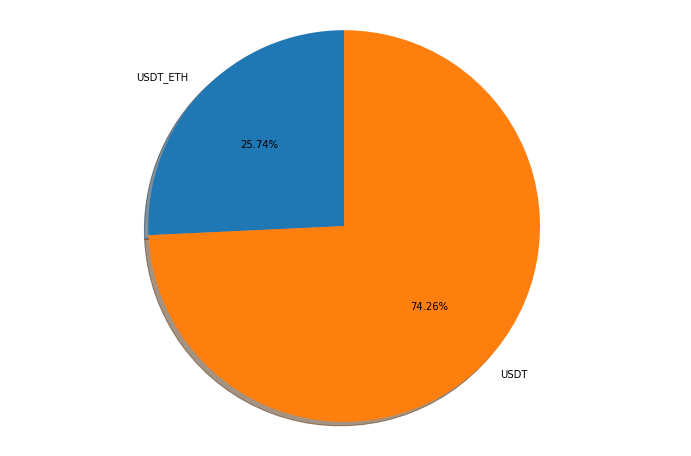

In [12]:
print('Total Portfolio Value: $ ' + str(round(total_holdings, 2)))
labels = holdings.coin
sizes = holdings.per_port
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.2f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [13]:
df_ticker['date'] = df_ticker.date.apply(lambda x: datetime.strftime(datetime.fromtimestamp(x), '%Y-%m-%d %H:%M:%S'))

In [14]:
date1 = '2018-09-25'
date2 = '2018-10-01'
mydates = pd.date_range(date1, date2, freq='4H').tolist()
mydates = [m.strftime('%Y-%m-%d %H:%M:%s') for m in mydates]
df_balance = pd.read_sql_query('select * from "balance" order by date',con=engine).drop('id', axis=1)
df_balance['date'] = df_balance.date.apply(lambda x: datetime.strftime(datetime.fromtimestamp(x), '%Y-%m-%d %H:%M:%S'))
df_balance.loc[df_balance['date'] >= '2018-09-26']

portfolios = pd.DataFrame(columns=['date', 'value'])
for d in mydates[:]:
    if d > datetime.now().strftime('%Y-%m-%d %H:%M:%s'):
        break
    current_values = []
    df = df_ticker.loc[df_ticker['date'] <= d].copy()
    if df.empty:
        continue
    
    for t in df_ticker.coin.unique():
        current_values.append({
            'coin': t,
            'date': df.loc[df['coin'] == t].sort_values('date').iloc[-1].date,
            'current_value': df.loc[df['coin'] == t].sort_values('date').iloc[-1].close
        })
    current_values = pd.DataFrame.from_records(current_values).copy().sort_values('date')
    
    holdings = current_values.drop(['date'], axis=1).merge(df_balance.loc[(df_balance['date'] <= d)].groupby(['coin']).sum().reset_index()[['coin', 'value']], on=['coin'])
    usdt_holdings = df_balance.loc[(df_balance['coin'] == 'USDT') & (df_balance['date'] <= d)].value.sum()
    holdings.loc[len(holdings)] = ['USDT', 1, usdt_holdings]
    holdings['value_usdt'] = holdings['current_value'] * holdings['value']    
    total_holdings = holdings['value_usdt'].sum()
    portfolios.loc[len(portfolios)] = [d, total_holdings]
portfolios['date'] = portfolios['date'].apply(lambda x: x[:17])

Total Portfolio % Change (24 h): -0.52 %
Total Portfolio % Change : -2.67 %


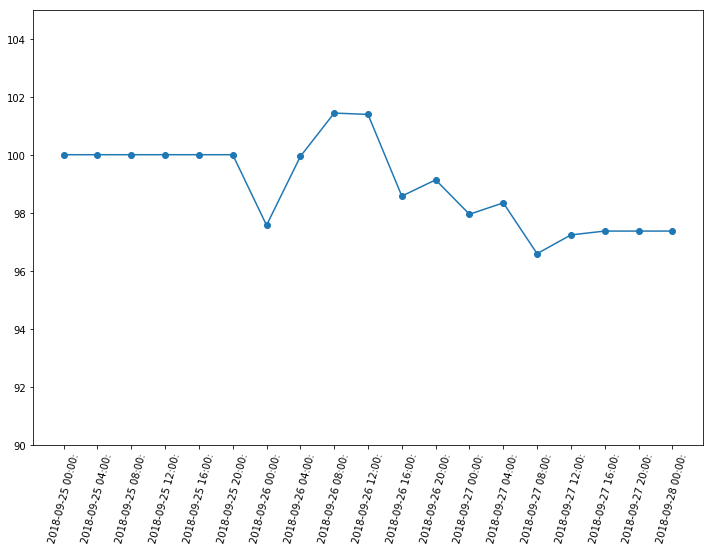

In [15]:
plt.plot(portfolios.date, portfolios.value, marker='o',)
plt.ylim([90, 105])
plt.xticks(rotation=75)
print('Total Portfolio % Change (24 h): ' + str(round(last_24_change * 100, 2)) + ' %')
print('Total Portfolio % Change : ' + str(round(change * 100, 2)) + ' %')
plt.show()

In [16]:
usdt_balance = holdings.loc[holdings['coin'] == 'USDT', 'value_usdt'].iloc[0]
print('USDT BALANCE: \n$ ' + str(round(usdt_balance,2)))

USDT BALANCE: 
$ 72.3


In [17]:
df_order_book = pd.read_sql_query('select * from "order_book" order by date',con=engine).drop('id', axis=1)
df_order_book['date'] = df_order_book['date'].apply(lambda x: datetime.strftime(datetime.fromtimestamp(x), '%Y-%m-%d %H:%M:%S'))
df_order_book['date_exit'] = df_order_book['date_exit'].apply(lambda x: x if np.isnan(x)  else datetime.strftime(datetime.fromtimestamp(x), '%Y-%m-%d %H:%M:%S'))
df_order_book['profit'] = df_order_book['exit'] * (df_order_book['volume'] * df_order_book['quote'])

In [18]:
print('Mean return: ' + str(df_order_book.exit.mean()))
df_order_book.sort_values('date')

Mean return: -0.016153685060917213


,coin,date,quote,volume,stop_loss,take_profit,status,exit,exit_quote,date_exit,profit
0,USDT_STR,2018-09-25 17:00:00,0.253167,98.749141,-0.009583,0.010000,close,-0.014390,0.249550,2018-09-26 17:00:00,-0.359755
1,USDT_ETH,2018-09-25 17:00:00,219.320000,0.113989,-0.003490,0.010000,close,-0.023664,214.190862,2018-09-26 21:00:00,-0.591609
2,USDT_ETH,2018-09-25 21:00:00,209.329680,0.119429,-0.003490,0.010000,close,0.039608,217.787150,2018-09-27 01:00:00,0.990195
3,USDT_ETH,2018-09-26 01:00:00,214.447587,0.116658,-0.003490,0.010000,close,-0.005835,213.200000,2018-09-27 05:00:00,-0.145966
4,USDT_DASH,2018-09-26 05:00:00,187.600000,0.133262,-0.009432,0.010000,close,-0.010699,185.603499,2018-09-27 09:00:00,-0.267484
5,USDT_XRP,2018-09-26 05:00:00,0.571835,43.718906,-0.004944,0.010000,close,-0.089182,0.523046,2018-09-27 09:00:00,-2.229541
6,USDT_XRP,2018-09-26 09:00:00,0.527729,47.372833,-0.004944,0.010000,close,-0.008913,0.523046,2018-09-27 09:00:00,-0.222834
7,USDT_ETH,2018-09-26 13:00:00,217.025340,0.115194,-0.003490,0.010000,open,nan,nan,NaN,nan


In [19]:
total_trades = len(df_order_book.loc[~df_order_book['exit'].isnull()])
print('Number of total trades: ' + str(total_trades))
print('-----------------------------------')
total_tp = len(df_order_book.loc[df_order_book['exit'] > 0])
print('Number of Take-profits: ' + str(total_tp))
print('-----------------------------------')
total_sl = len(df_order_book.loc[df_order_book['exit'] < 0])
print('Number of Stop-loss: ' + str(total_sl))
print('-----------------------------------')
total_open = len(df_order_book.loc[df_order_book['exit'].isnull()])
print('Number of Open Trades: ' + str(total_open))
print('-----------------------------------')

Number of total trades: 7
-----------------------------------
Number of Take-profits: 1
-----------------------------------
Number of Stop-loss: 6
-----------------------------------
Number of Open Trades: 1
-----------------------------------
